In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [4]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]

In [15]:
df = pd.read_csv("SeoulBikeData.csv", encoding='unicode_escape').drop(["Date", "Holiday", "Seasons"], axis = 1)

In [25]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [26]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


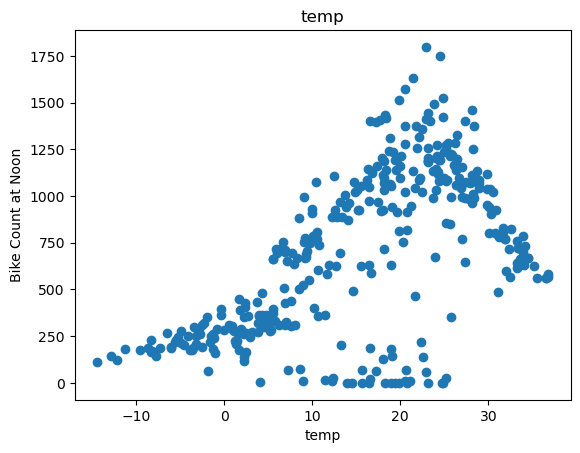

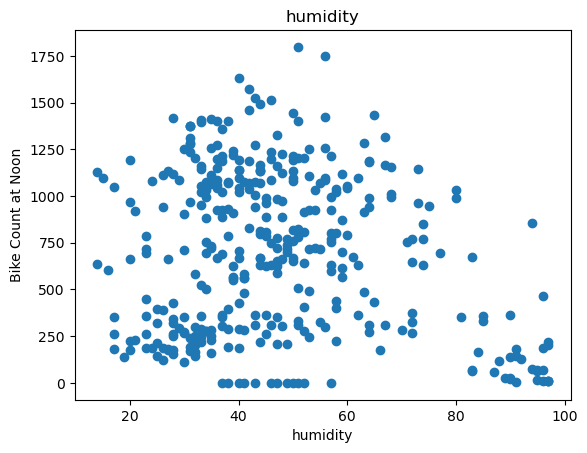

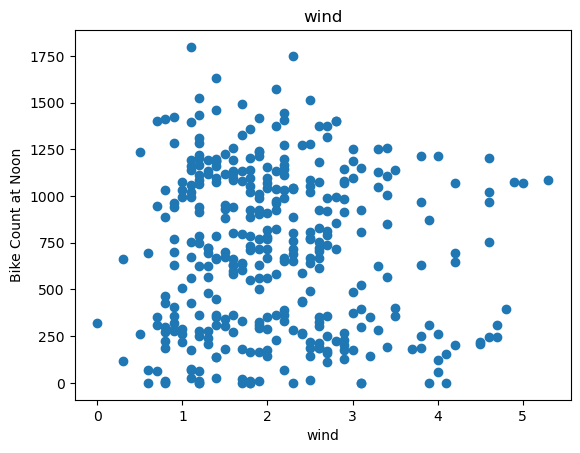

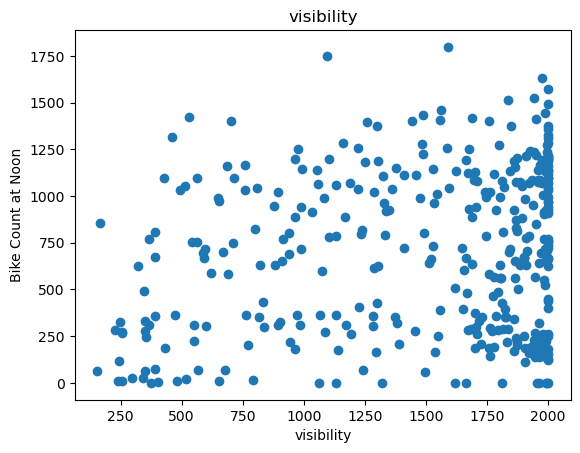

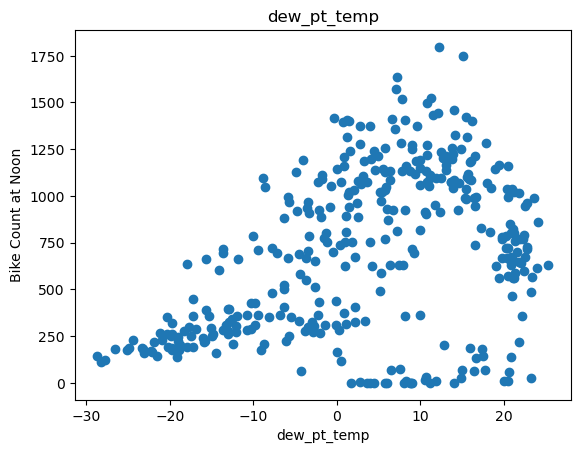

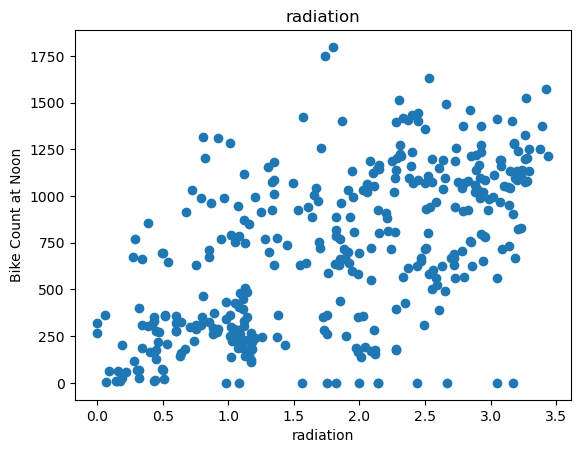

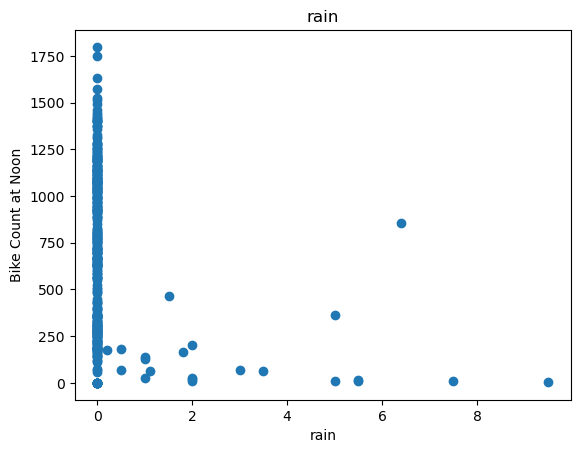

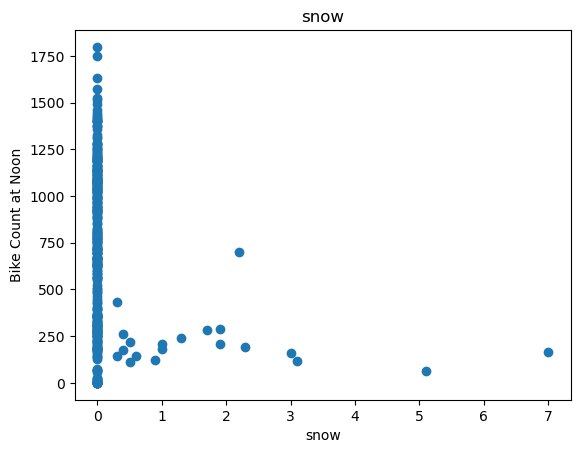

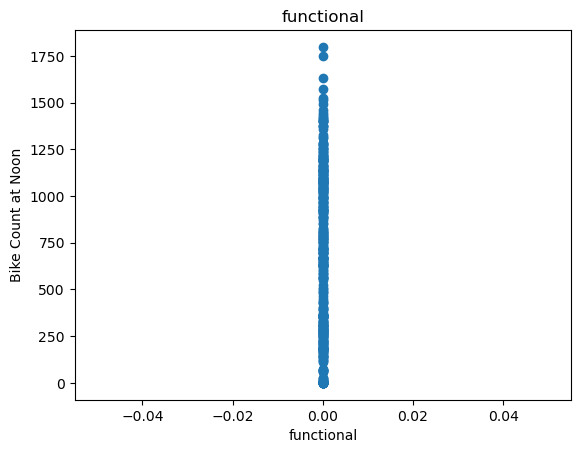

In [28]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()

In [29]:
df = df.drop(["wind", "visibility", "functional"], axis = 1) #nisu linearni

In [30]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


Train/valid/test dataset

In [58]:
train, val, test = np.split(df.sample(frac = 1), [int(0.6*len(df)), int(0.8*len(df))])

C:\Users\kovac_impo9dd\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [59]:
def get_xy(dataframe, y_label, x_labels = None):
    dataframe = copy.deepcopy(dataframe)
    if  x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!= y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X, y))

    return data, X, y

In [60]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [61]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [62]:
temp_reg.score(X_test_temp, y_test_temp)

0.33392988198342854

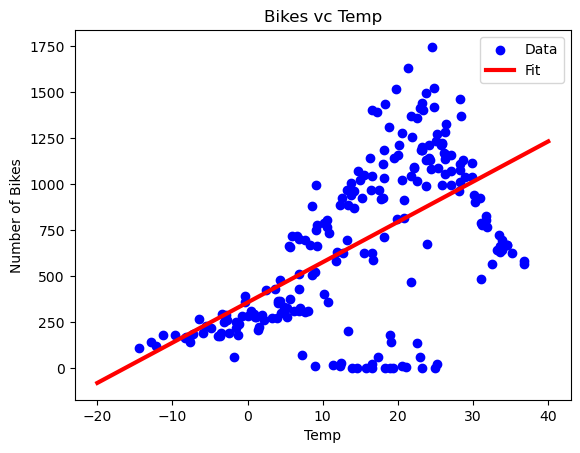

In [63]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes vc Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

Multiple Linear Regression

In [64]:
train, val, test = np.split(df.sample(frac = 1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

C:\Users\kovac_impo9dd\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [65]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [66]:
all_reg.score(X_test_all, y_test_all)

0.5270321485573699

Regressioin with Neural Network

In [69]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [70]:
temp_nn_model = tf.keras.Sequential ([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [71]:
temp_nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = 'mean_squared_error')

In [72]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs = 1000,
    validation_data=(X_val_temp, y_val_temp)
)

In [73]:
def plot_loss(history):
    plt.plot(history.history['loss'], label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

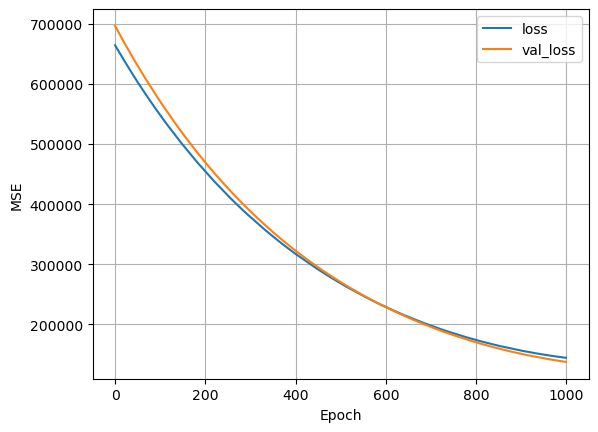

In [74]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


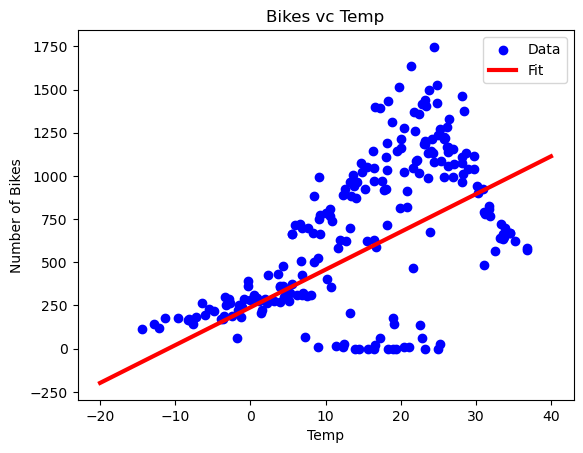

In [77]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes vc Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

Neural Network

In [85]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1),
])

nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error')

In [86]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data = (X_val_temp, y_val_temp),
    verbose = 0, epochs = 100
)

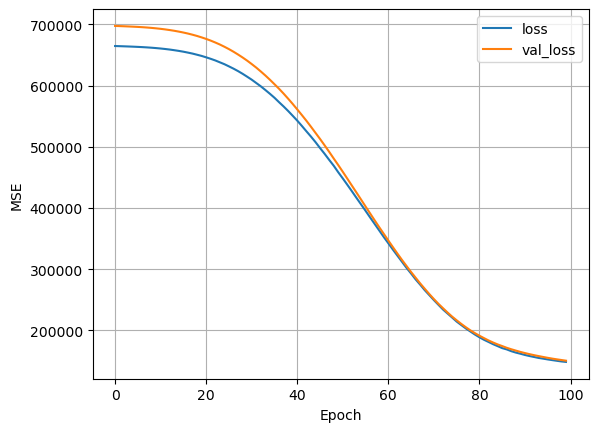

In [87]:
plot_loss(history)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000176C15B3A60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


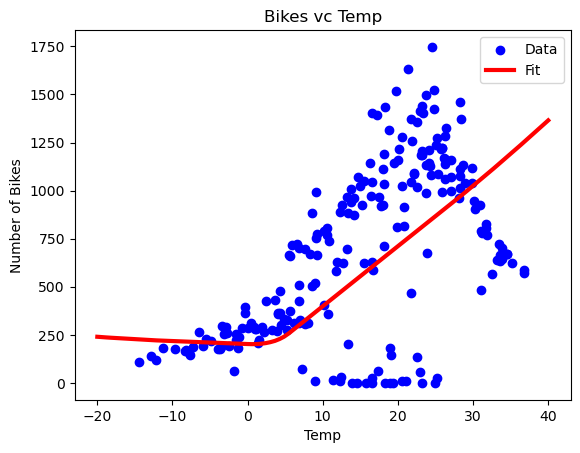

In [88]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color = "red", linewidth = 3)
plt.legend()
plt.title("Bikes vc Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

calculate the MSE for linear reg

In [90]:
y_pred_lr = all_reg.predict(X_test_all)

In [91]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [92]:
MSE(y_pred_lr, y_test_all)

80874.63550089822